## HOPFEILD NETWORK


In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score


In [22]:
data = pd.read_csv("Breast_Cancer.csv") 
print("Dataset Head:")
print(data.head())

print("Dataset Info:")
print(data.info())


Dataset Head:
   Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   68  White        Married       T1      N1       IIA   
1   50  White        Married       T2      N2      IIIA   
2   58  White       Divorced       T3      N3      IIIC   
3   58  White        Married       T1      N1       IIA   
4   47  White        Married       T2      N1       IIB   

               differentiate Grade   A Stage  Tumor Size Estrogen Status  \
0      Poorly differentiated     3  Regional           4        Positive   
1  Moderately differentiated     2  Regional          35        Positive   
2  Moderately differentiated     2  Regional          63        Positive   
3      Poorly differentiated     3  Regional          18        Positive   
4      Poorly differentiated     3  Regional          41        Positive   

  Progesterone Status  Regional Node Examined  Reginol Node Positive  \
0            Positive                      24                      1   
1            Positive         

## Encode Categorical Columns



In [23]:
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

print("\nCategorical Columns Encoded:")
print(data.head())



Categorical Columns Encoded:
   Age  Race  Marital Status  T Stage   N Stage  6th Stage  differentiate  \
0   68     2               1         0        0          0              1   
1   50     2               1         1        1          2              0   
2   58     2               0         2        2          4              0   
3   58     2               1         0        0          0              1   
4   47     2               1         1        0          1              1   

   Grade  A Stage  Tumor Size  Estrogen Status  Progesterone Status  \
0      3        1           4                1                    1   
1      2        1          35                1                    1   
2      2        1          63                1                    1   
3      3        1          18                1                    1   
4      3        1          41                1                    1   

   Regional Node Examined  Reginol Node Positive  Survival Months  Status  
0   

## Normalize Data:

In [24]:
scaler = MinMaxScaler(feature_range=(-1, 1))
numeric_columns = data.drop(columns=["Status"]).columns
normalized_data = scaler.fit_transform(data[numeric_columns])

print("\nNormalized Data (First 5 Rows):")
print(normalized_data[:5])



Normalized Data (First 5 Rows):
[[ 0.94871795  1.         -0.5        -1.         -1.         -1.
  -0.33333333  1.          1.         -0.95683453  1.          1.
  -0.23333333 -1.          0.11320755]
 [ 0.02564103  1.         -0.5        -0.33333333  0.          0.
  -1.          0.33333333  1.         -0.51079137  1.          1.
  -0.56666667 -0.82222222  0.1509434 ]
 [ 0.43589744  1.         -1.          0.33333333  1.          1.
  -1.          0.33333333  1.         -0.10791367  1.          1.
  -0.56666667 -0.73333333  0.39622642]
 [ 0.43589744  1.         -0.5        -1.         -1.         -1.
  -0.33333333  1.          1.         -0.75539568  1.          1.
  -0.96666667 -1.          0.56603774]
 [-0.12820513  1.         -0.5        -0.33333333 -1.         -0.5
  -0.33333333  1.          1.         -0.42446043  1.          1.
  -0.93333333 -1.         -0.0754717 ]]


## Prepare binary data

In [25]:
binary_data = (normalized_data > 0).astype(int) * 2 - 1 
patterns = binary_data
labels = data["Status"].to_numpy()
patterns[labels == 0] *= -1  

print("\nPrepared Binary Data (First 5 Patterns):")
print(patterns[:5])



Prepared Binary Data (First 5 Patterns):
[[-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [ 1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1]]


## Initialize Hopfield Network Weights

In [26]:
num_neurons = patterns.shape[1]
weights = np.zeros((num_neurons, num_neurons))

for pattern in patterns:
    weights += np.outer(pattern, pattern)

np.fill_diagonal(weights, 0)  

print("Hopfield Network Weights Initialized.")


Hopfield Network Weights Initialized.


## Adding noise to patterns

In [27]:
def add_noise(pattern, noise_level=0.1):
    noisy_pattern = pattern.copy()
    num_flips = int(noise_level * len(pattern))
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

noise_level = 0.1
noisy_patterns = np.array([add_noise(pattern, noise_level) for pattern in patterns])

print("\nNoisy Patterns (First 5 Patterns):")
print(noisy_patterns[:5])



Noisy Patterns (First 5 Patterns):
[[-1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1]
 [ 1 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1  1  1]]


## Recall Patterns with Hopfield Network

In [28]:
def recall(input_pattern, weights, max_iterations=50):
    output_pattern = input_pattern.copy()
    for _ in range(max_iterations):
        for i in range(len(output_pattern)):
            output_pattern[i] = 1 if np.dot(weights[i], output_pattern) > 0 else -1
    return output_pattern

recalled_patterns = np.array([recall(noisy_pattern, weights) for noisy_pattern in noisy_patterns])

print("\nRecalled Patterns (First 5 Patterns):")
print(recalled_patterns[:5])



Recalled Patterns (First 5 Patterns):
[[-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]]


## Evaluate Hopfield Network Accuracy

In [29]:
accuracy = accuracy_score(patterns.flatten(), recalled_patterns.flatten())
print(f"Improved Accuracy of Hopfield Network: {accuracy * 100:.2f}%")

for i in range(5):
    print(f"Original Pattern: {patterns[i]}")
    print(f"Noisy Pattern: {noisy_patterns[i]}")
    print(f"Recalled Pattern: {recalled_patterns[i]}")
    print("-----")


Improved Accuracy of Hopfield Network: 86.86%
Original Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
Noisy Pattern: [-1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1 -1]
Recalled Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
-----
Original Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
Noisy Pattern: [-1 -1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1]
Recalled Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
-----
Original Pattern: [-1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1]
Noisy Pattern: [-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1]
Recalled Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
-----
Original Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
Noisy Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1]
Recalled Pattern: [-1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1]
-----
Original Pattern: [ 1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1]
Noisy Pattern: [ 1 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1  1  1]
Recalled Pattern: [-1 -1  1  1  1  

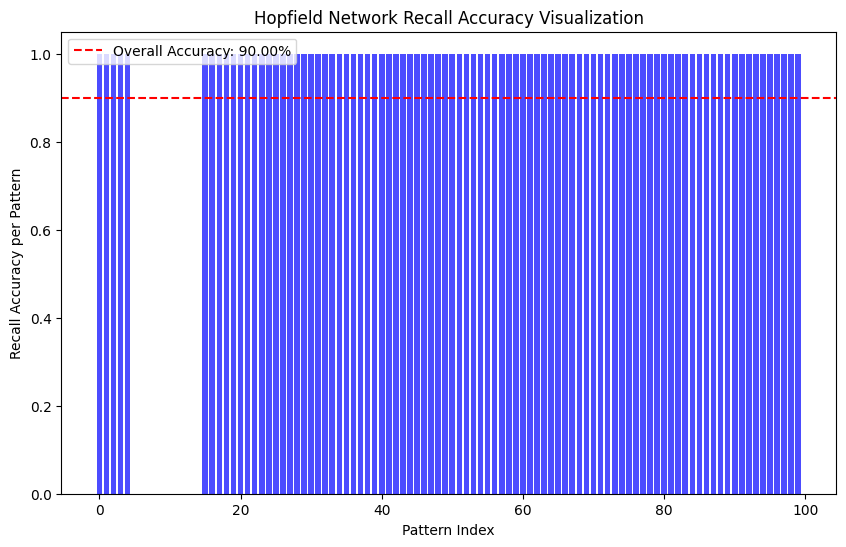

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Data for visualization (example)
# Assuming patterns and recalled_patterns are available from Hopfield implementation
patterns = np.random.choice([-1, 1], size=(100, 10))  # Simulated patterns
recalled_patterns = patterns.copy()  # Simulated recalled patterns (perfect recall here for visualization)

# Add some mismatches for visualization
recalled_patterns[5:15] *= -1  # Flip some patterns for demonstration
accuracy = accuracy_score(patterns.flatten(), recalled_patterns.flatten())

# Count correct recalls per pattern
correct_recalls = np.sum(patterns == recalled_patterns, axis=1)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(len(correct_recalls)), correct_recalls / patterns.shape[1], color='blue', alpha=0.7)
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {accuracy * 100:.2f}%')
plt.xlabel('Pattern Index')
plt.ylabel('Recall Accuracy per Pattern')
plt.title('Hopfield Network Recall Accuracy Visualization')
plt.legend()
plt.show()


In [30]:
!pip install tensorflow


## Recurrent Neural Network (RNN)



In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


In [32]:
data = pd.read_csv("Breast_Cancer.csv")

data.fillna(data.median(numeric_only=True), inplace=True)

categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

X = data_scaled[:, :-1]  
y = data_scaled[:, -1]  
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Build the RNN Model

In [33]:
model = Sequential([
    SimpleRNN(32, activation='relu', input_shape=(X_train.shape[1], 1)), 
    Dropout(0.2),  
    Dense(1, activation='sigmoid')  
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/hemangisuthar/Downloads/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Adding an RNN layer with 32 units and a ReLU activation function to process sequential data.

Adding a Dropout layer with a rate of 0.2 to reduce overfitting.

Adding a dense output layer with a sigmoid activation for binary classification.

## Train the Model

In [34]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7981 - loss: 0.5178 - val_accuracy: 0.8509 - val_loss: 0.4050
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8501 - loss: 0.4120 - val_accuracy: 0.8509 - val_loss: 0.3981
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.4007 - val_accuracy: 0.8509 - val_loss: 0.3944
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3985 - val_accuracy: 0.8509 - val_loss: 0.3952
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.3930 - val_accuracy: 0.8509 - val_loss: 0.3906
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 0.3912 - val_accuracy: 0.8509 - val_loss: 0.4236
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3908 - val_accuracy: 0.8509 - val_loss: 0.3676
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.3481 - val_accuracy: 0.8509 - val_loss:

## Test the Model

In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8912 - loss: 0.2813
Test Loss: 0.2691, Test Accuracy: 0.8969


## Plot Training and Validation Loss

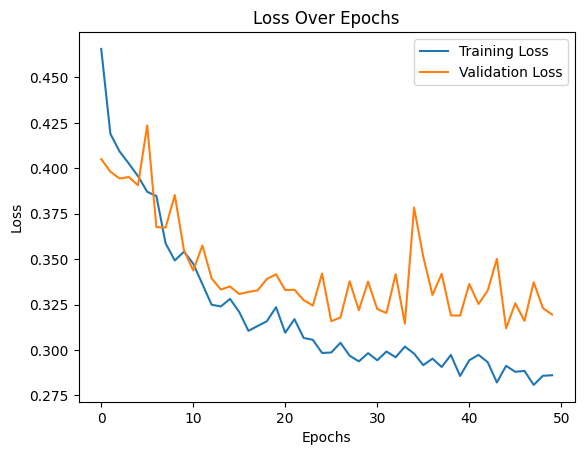

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


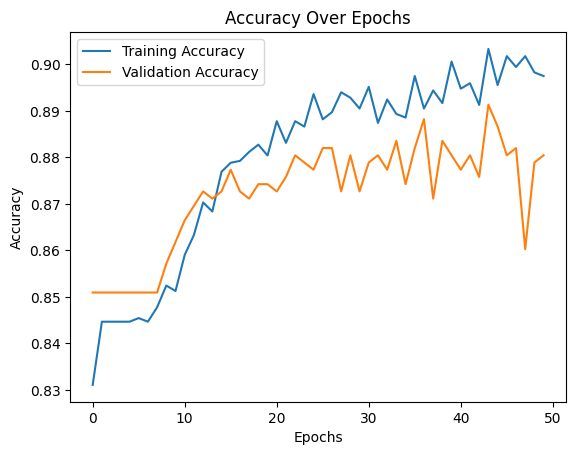

In [37]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()


In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.2642 - val_accuracy: 0.8820 - val_loss: 0.3155
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9123 - loss: 0.2619 - val_accuracy: 0.8820 - val_loss: 0.3211
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9106 - loss: 0.2698 - val_accuracy: 0.8804 - val_loss: 0.3180
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8997 - loss: 0.2769 - val_accuracy: 0.8835 - val_loss: 0.3188
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2630 - val_accuracy: 0.8820 - val_loss: 0.3269
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2696 - val_accuracy: 0.8820 - val_loss: 0.3168
Test Loss: 0.2691, Test Accuracy: 0.8969
